In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Convolutional Neural Network
### Fashion MNIST Dataset

In [11]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from collections.abc import Callable
from typing import Literal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

%matplotlib inline

In [12]:
gpus = tf.config.list_physical_devices('GPU')

try:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print (len(gpus), 'Phusical GPUs', len(logical_gpus), 'Logical GPUs')
except:
    print ('invalid device')

1 Phusical GPUs 1 Logical GPUs


In [13]:
###----------------
### Some parameters
###----------------

inpDir = '../../input'
outDir = '../output'
subDir = 'Shakespeare'
modelDir = '.../models'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
BATCH_SIZE = 32
LR_PATIENCE = 2
FACTOR_LR = 0.5
TRAIN_SIZE = 256 # fix size of train set sot that we have batches of same size
PATIENCE = 4

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

In [14]:


def fn_plot_label(train_df : pd.DataFrame, test_df : pd.DataFrame):

    plt.figure(figsize=(15,5))

    plt.plot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title= 'Training distribution',
                                               color= 'DarkBlue', alpha= 0.8)

    plt.subplot(1,2,2)

    ax = test_df['label'].value_counts().plot(kind='bar',
                                               title= 'Testing distribution',
                                               color= 'Orange', alpha= 0.8)


## Generate Data Set
Fashion MINST Dataset

In [15]:
class_label = {0 : 'T-shirt/Top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'}

In [16]:
train_df = pd.read_csv('fashion-mnist_train.csv', header=0)

test_df = pd.read_csv('fashion-mnist_test.csv', header=0)

In [17]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<ipython-input-14-54035a2fdb47>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)


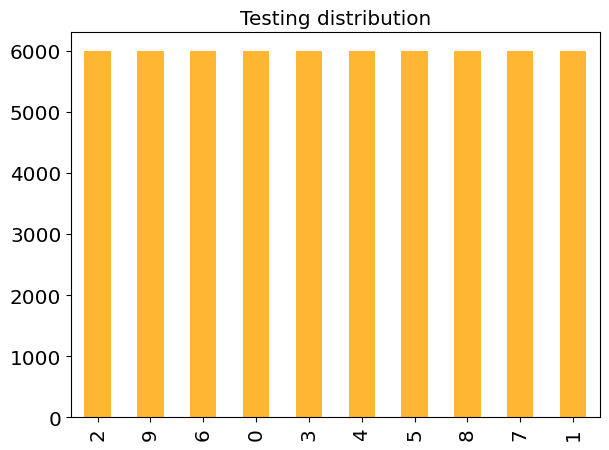

In [19]:
fn_plot_label(test_df, train_df)

### Converting to Datasets

In [20]:
def fn_split_feature_labels (row):

    feature = tf.reshape(row[1:], [28,28,1])

    label = row[0]

    return feature, label


In [21]:
# Create a training dataset

#--------------
# Traning Data
#--------------

tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(fn_split_feature_labels)

train_ds = train_ds.batch(BATCH_SIZE)
#--------------
# Testing Data
#--------------

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(fn_split_feature_labels)

test_ds = test_ds.batch(BATCH_SIZE)


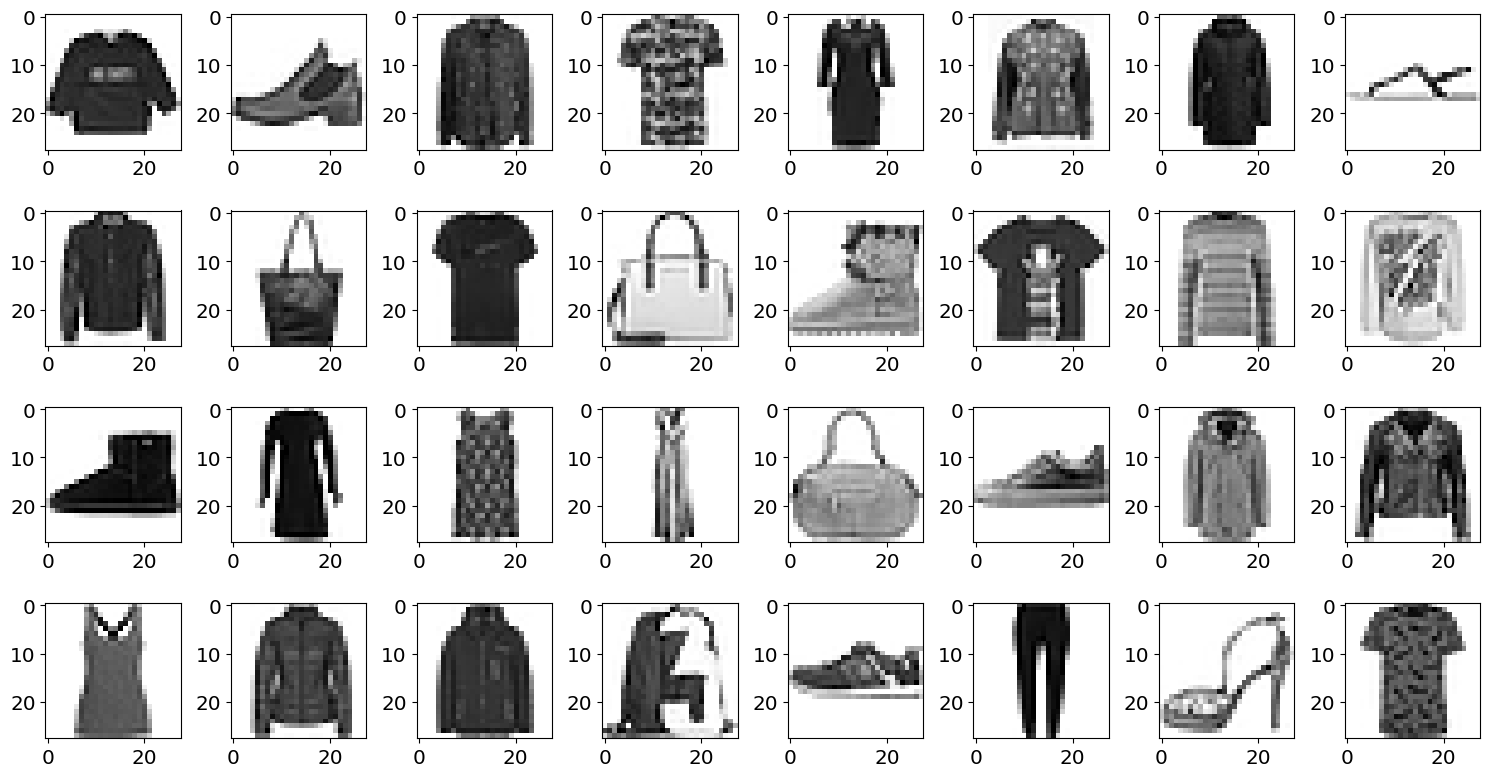

In [22]:
for images, labels in train_ds.take(1):

    #print(images.shape, labels)

    for i in range(BATCH_SIZE):

        rows = 4

        plt.subplot(4, BATCH_SIZE//rows, i+1)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary) # type: ignore
        plt.grid(False)

    plt.tight_layout()

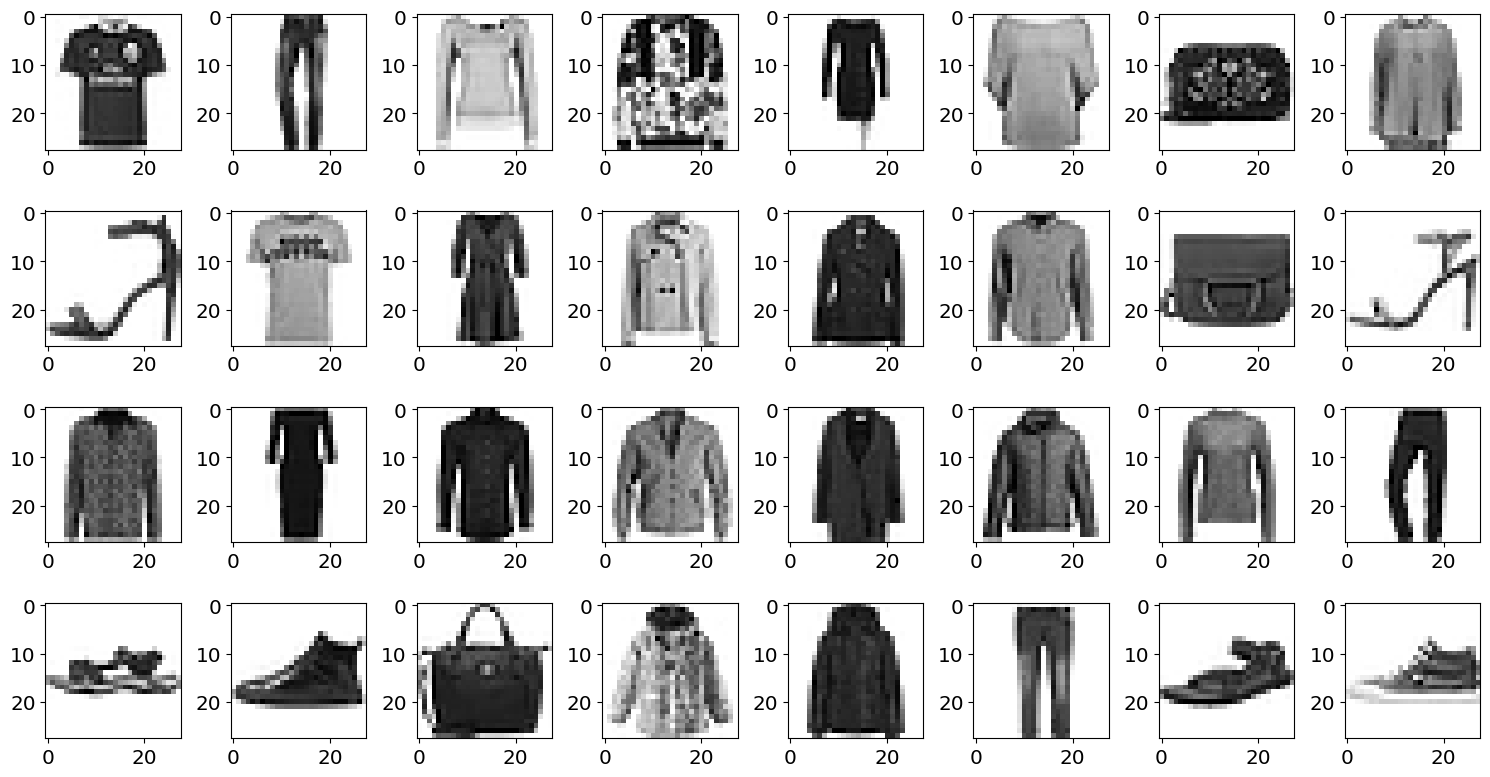

In [23]:
for images, labels in test_ds.take(1):

    #print(images.shape, labels)

    for i in range(BATCH_SIZE):

        rows = 4

        plt.subplot(4, BATCH_SIZE//rows, i+1)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary) # type: ignore
        plt.grid(False)

    plt.tight_layout()

In [24]:
#images[0]

In [25]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
dor1 = 0



model = tf.keras.Sequential([

    tf.keras.layers.Rescaling(1/255.), #28, 28, 3

    ###-------
    ### Set 1
    ###-------

    tf.keras.layers.Conv2D(32, (3,3),
                            padding = 'same',
                            activation = 'relu',
                            input_shape = (29, 28, 1)), # 28 x 28 x 32
    ###---------
    ### Pooling
    ###---------

    tf.keras.layers.MaxPooling2D((2, 2)), # 14 x 14 x 32

    ###-------
    ### Set 2
    ###-------
    # Conv layer
    tf.keras.layers.Conv2D(64, (3,3),
                            padding = 'same',
                            activation = 'relu'), # 12 x 12 x 24

    ### Pooling

    tf.keras.layers.MaxPooling2D((2, 2)), # 6 x 6 x 64

    ###-------
    ### Set 3
    ###-------
    # Conv 3
    tf.keras.layers.Conv2D(128, (3,3),
                            padding = 'same',
                            activation = 'relu'), # 4 x 4 x 128

    tf.keras.layers.Flatten(),

    ###--------------
    ### Dense Layers
    ###--------------
    # Dense 1
    tf.keras.layers.Dense(512, activation = 'relu'),

    #Dense 2
    tf.keras.layers.Dense(10)

])



In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    mode = 'auto',
    baseline = None,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=0,
)
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto',

)


In [28]:
optim = tf.keras.optimizers.Adam(learning_rate = ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model.compile(optimizer = optim, loss = loss_fn, metrics = ['accuracy'])

In [29]:
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, verbose = 1,batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, lr_decay])

Epoch 1/10
1875/1875 [==============================] - 24s 7ms/step - loss: 0.3783 - accuracy: 0.8619 - val_loss: 0.2699 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2424 - accuracy: 0.9102 - val_loss: 0.2410 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1895 - accuracy: 0.9300 - val_loss: 0.2492 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 4/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9466
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1439 - accuracy: 0.9466 - val_loss: 0.2652 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0921 - accuracy: 0.9664 - val_loss: 0.2481 - val_accuracy: 0.9251 - lr: 5.0000e-04
Epoch 6/10
1875/1875 [======================

In [30]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "{}: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()

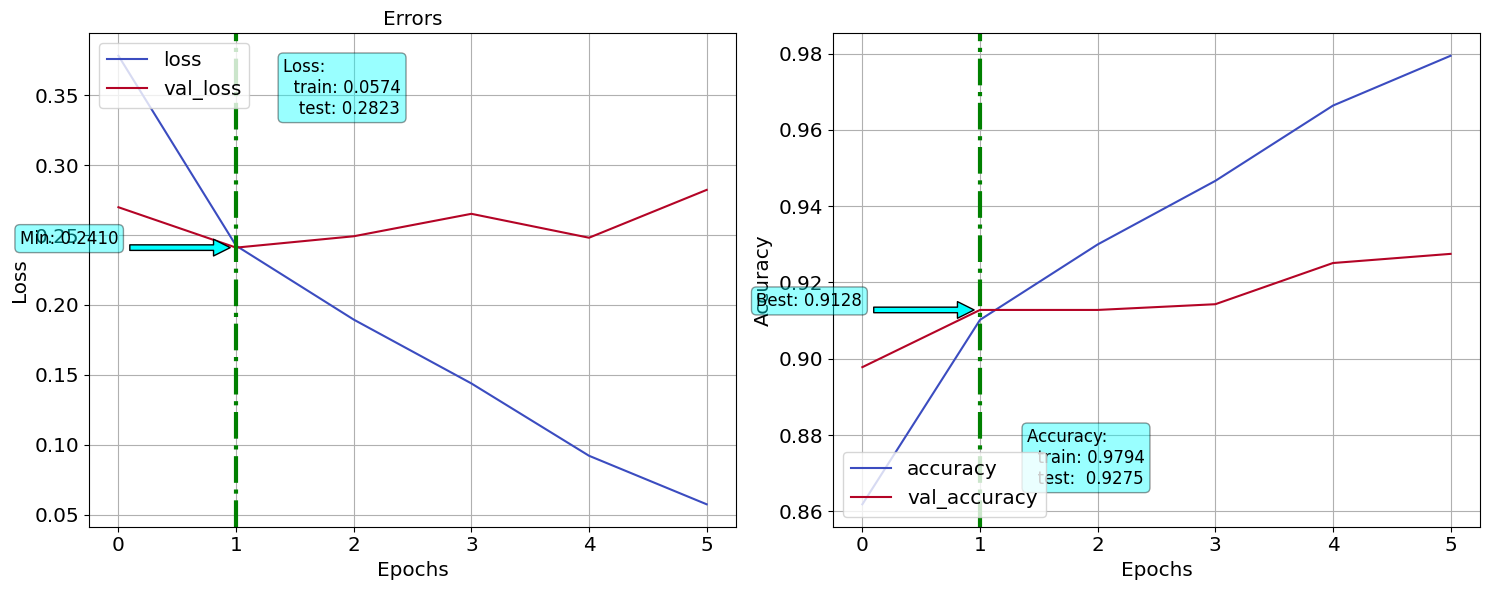

In [31]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [32]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy,lr
1,0.242431,0.9102,0.241035,0.9128,0.001
